# Step 0: set work directories, extract paths, summarize

In [0]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import scipy.io as scio
from collections import OrderedDict 
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from time import time

In [2]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
print("Auth Success")

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Auth Success


First upload train_set.zip to google drive, and please replace the *id* of the zip file.

In [3]:
download = drive.CreateFile({'id': '1K6KCo5fM-XfWbMamVQNuCSPUTBUuJ8nR'}) #please replace the id of your file
download.GetContentFile('train_set.zip')
!unzip train_set.zip

Archive:  train_set.zip
   creating: train_set/
  inflating: train_set/.DS_Store     
   creating: __MACOSX/
   creating: __MACOSX/train_set/
  inflating: __MACOSX/train_set/._.DS_Store  
   creating: train_set/images/
  inflating: train_set/images/0071.jpg  
   creating: __MACOSX/train_set/images/
  inflating: __MACOSX/train_set/images/._0071.jpg  
  inflating: train_set/images/2100.jpg  
  inflating: __MACOSX/train_set/images/._2100.jpg  
  inflating: train_set/images/0717.jpg  
  inflating: __MACOSX/train_set/images/._0717.jpg  
  inflating: train_set/images/1409.jpg  
  inflating: __MACOSX/train_set/images/._1409.jpg  
  inflating: train_set/images/0703.jpg  
  inflating: __MACOSX/train_set/images/._0703.jpg  
  inflating: train_set/images/2114.jpg  
  inflating: __MACOSX/train_set/images/._2114.jpg  
  inflating: train_set/images/0065.jpg  
  inflating: __MACOSX/train_set/images/._0065.jpg  
  inflating: train_set/images/1353.jpg  
  inflating: __MACOSX/train_set/images/._1353.jpg

# Step 1: set up controls for evaluation experiments.


# Step 2: import data and train-test split 

In [11]:
########## Importing the fidusial points ##########
points_path = 'train_set/points'
points = [p for p in sorted(os.listdir(points_path))]
all_points = []
for p in points:
  poiFile = os.path.join(points_path, p)
  poi = scio.loadmat(poiFile)
  poi = OrderedDict(poi)
  all_points.append(poi.popitem()[1])
y = pd.read_csv('train_set/label.csv')['emotion_idx']

success


# Step 3: construct features and responses

In [74]:
########## Calculating pairwise distance ##########
pair_dist = []
for i in range(len(all_points)):
  pair_dist.append(metrics.pairwise_distances(all_points[i])[np.triu_indices(78)])

########## Split train_set & test_set ##########
points_train, points_test, y_train, y_test = train_test_split(pair_dist, y, random_state=42, test_size=0.2)
print('success')

success


# Step 4: Train a classification model with training features and responses

## SVM

In [0]:
########## Scaling datasets ##########
points_train_np = np.array(points_train)
points_test_np = np.array(points_test)
y_train_np = np.array(y_train)
y_test_np = np.array(y_test)
points_train_scale = scale(points_train_np)
points_test_scale = scale(points_test_np)

In [0]:
########## PCA Modules ###########

#n_comp = 1000
#pca = PCA(n_components=n_comp, svd_solver='randomized',
#          whiten=True).fit(points_train_np)
#points_train_pca = pca.transform(points_train_np)
#points_test_pca = pca.transform(points_test_np)

KeyboardInterrupt: ignored

In [78]:
###### Tunning Modules #########
tunning = False
t0 = time()

if tunning:
  param_grid = {'C': [1,5,10],
              'gamma': [0.00001,0.0001,0.01], }
  clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                   param_grid, cv=5, iid=False)
  clf = clf.fit(points_train_scale, y_train)
  print("done in %0.3fs" % (time() - t0))
  print("Best estimator found by grid search:")
  print(clf.best_estimator_)

done in 1003.080s
Best estimator found by grid search:
SVC(C=10, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


In [76]:
########## Training Modules ##########
###### if tunning is true, there is no need to train the model again ########
t0 = time()
clf = SVC(kernel="rbf", class_weight="balanced",C=10,gamma=0.0001)
clf = clf.fit(points_train_scale, y_train)
print("Training done in %0.3fs" %(time() -t0))

Training done in 15.888s


In [77]:
######## Prediction on test_set #########
t0 = time()
y_pred = clf.predict(points_test_scale)
acc_pred = np.sum(y_pred == y_test)/y_test.shape[0]
print("Prediction on test_set done in %0.3fs" % (time() - t0))
print("Test_set accurarcy is %0.3f" %acc_pred)

Prediction on test_set done in 5.600s
Test_set accurarcy is 0.506


In [73]:
######## Prediction on train_set #########
t0 = time()
y_pred_train = clf.predict(points_train_scale)
acc_pred_train = np.sum(y_pred_train == y_train)/y_train.shape[0]
print("Prediction on train_set done in %0.3fs" % (time() - t0))
print("Train_set accurarcy is %0.3f" %acc_pred_train)

Prediction on train_set done in 21.807s
Train_set accurarcy is 0.806


In [48]:
y_pred_train = clf.predict(points_train_scale)
np.sum(y_pred_train == y_train)/y_train.shape[0]

0.8755

In [0]:
C=10
C1=8
gamma=0.0001

In [50]:
1/2000

0.0005

## GBM & CV(not yet finished)(Baseline Model)

In [0]:
y_pred

array([14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
       14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
       14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
       14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
       14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
       14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14])

In [0]:

start = time.time()
gbm0 = GradientBoostingClassifier(random_state=10)
gbm0.fit(points_train, y_train)
finish = time.time()
print("Time：%f s" %(finish-start))
pred = gbm0.predict(points_test)
print("Accuracy : %.4g" % metrics.accuracy_score(y_train, pred))

Time：1602.105760 s


ValueError: ignored

## CNN & CV

In [0]:
!rm train_set/images/.DS_Store

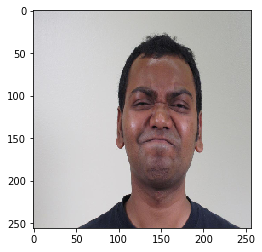

In [0]:
images_path = 'train_set/images'
all_images = []
images = [i for i in sorted(os.listdir(images_path))]
for i in images:
  imgFile = os.path.join(images_path, i)
  img = image.load_img(os.path.join(images_path, i), grayscale=False, target_size=(256,256,3))
  img = image.img_to_array(img)
  img = img/255
  all_images.append(img)
all_images = np.array(all_images)
plt.imshow(img)

In [0]:
y_onehot = to_categorical(y)
img_train, img_test, y_train_cnn, y_test_cnn = train_test_split(all_images, y, random_state=42, test_size=0.2)

In [0]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3),padding='same',input_shape=(256,256,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(23))
model.add(Activation('softmax'))

In [0]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

In [0]:
start = time.time()
model.fit(img_train, y_train_cnn, epochs=10, validation_data=(img_test, y_test_cnn))
finish = time.time()
print("Time：%f s" %(finish-start))

Train on 2000 samples, validate on 500 samples
Epoch 1/10
2000/2000 [==============================] - 165s 83ms/step - loss: 2.3776 - acc: 0.3005 - val_loss: 3.8635 - val_acc: 0.1660
Epoch 2/10
2000/2000 [==============================] - 168s 84ms/step - loss: 2.0862 - acc: 0.3505 - val_loss: 12.6602 - val_acc: 0.0580
Epoch 3/10
2000/2000 [==============================] - 161s 81ms/step - loss: 1.8929 - acc: 0.3885 - val_loss: 7.9061 - val_acc: 0.0900
Epoch 4/10
2000/2000 [==============================] - 159s 80ms/step - loss: 1.6128 - acc: 0.4745 - val_loss: 3.5415 - val_acc: 0.1400
Epoch 5/10
2000/2000 [==============================] - 159s 80ms/step - loss: 1.5754 - acc: 0.4640 - val_loss: 3.6129 - val_acc: 0.1600
Epoch 6/10
 736/2000 [==========>...................] - ETA: 1:35 - loss: 1.1399 - acc: 0.6223

In [0]:
prediction = model.predict_classes(img_train)
metrics.accuracy_score(y_train_cnn, prediction)

In [0]:
prediction = model.predict_classes(img_test)
metrics.accuracy_score(y_test_cnn, prediction)

# Step 5: Run test on test images

# Summarize Running Time